# Example 1 - linear regression

Using both Stan and pyMC for the same simple model. The point of this series of tutorials is to find out which of the two libraries will be kept in the published version of Poem.

* Data loading and preprocessing
* Model definition and choice of prior
* Model fitting and diagnostics
* Model checking and prediction

This is a M&V tutorial: as a last step, we will calculate energy savings by substracting "post" consumption from the consumption predicted by the model trained on the "pre" period.

In [4]:
# All imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

In [5]:
df = pd.read_csv("../data/pmva.csv")
df.head()

,observation,consumption,HDD,CLASSDAYS,period
0,1,321120,12.7,0.0,pre
1,2,335520,19.4,6.0,pre
2,3,412560,147.6,20.0,pre
3,4,394560,353.4,20.0,pre
4,5,424080,526.7,20.0,pre


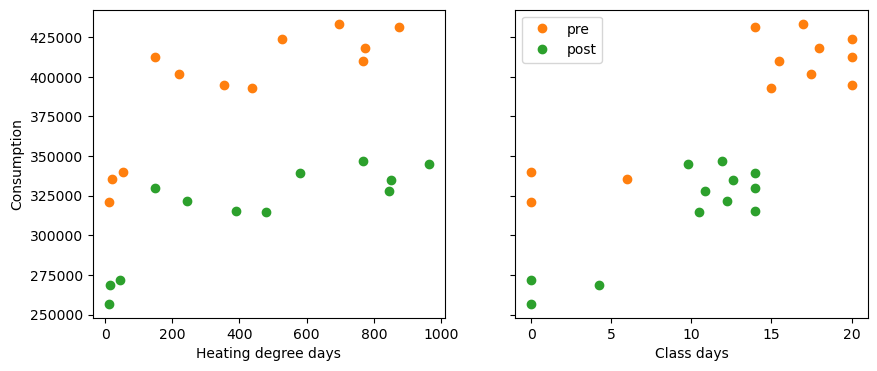

In [17]:
df_pre  = df[df.period == 'pre']
df_post = df[df.period == 'post']

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax[0].plot(df_pre['HDD'],  df_pre['consumption'],  marker="o", ls="", color="C1")
ax[0].plot(df_post['HDD'], df_post['consumption'], marker="o", ls="", color="C2")
ax[1].plot(df_pre['CLASSDAYS'],  df_pre['consumption'],  marker="o", ls="", color="C1", label="pre")
ax[1].plot(df_post['CLASSDAYS'], df_post['consumption'], marker="o", ls="", color="C2", label="post")
ax[0].set_xlabel('Heating degree days')
ax[0].set_ylabel('Consumption')
ax[1].set_xlabel('Class days')
ax[1].legend()

# Model specification and fitting with Stan

Pystan requires Linux, which may not be used by all Poem users. It is also no longer under development. We will use cmdstanpy instead:
https://mc-stan.org/cmdstanpy/index.html


In [33]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file='../models_stan/linearregression.stan')

The sample() method is used to do Bayesian inference over the model conditioned on data using using Hamiltonian Monte Carlo (HMC) sampling. It runs Stan’s HMC-NUTS sampler on the model and data and returns a CmdStanMCMC object. The data can be specified either as a filepath or a Python dictionary.
* CmdStan is a file-based interface, therefore all model input and initialization data must be supplied as JSON files, as described in the [CmdStan User’s Guide](https://mc-stan.org/docs/cmdstan-guide/json_apdx.html#creating-json-files).
* CmdStanPy inference methods allow inputs and initializations to be specified as in-memory Python dictionary objects which are then converted to JSON.

In [30]:
model_data = {
    "N": len(df_pre),
    "K": 2,
    "x": df_pre[['HDD', 'CLASSDAYS']],
    "y": df_pre['consumption'],
}

fit = model.sample(data=model_data)

14:12:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

14:12:01 - cmdstanpy - INFO - CmdStan done processing.
14:12:02 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


[CmdStan utilities: stansummary, diagnose](https://mc-stan.org/cmdstanpy/users-guide/hello_world.html#cmdstan-utilities-stansummary-diagnose)

In [ ]:
fit.summary()
# print(fit.diagnose())

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-110.0300,0.050623,1.68449,1.49594,-113.2170,-109.6910,-108.038,1208.65,1401.73,1.00497
alpha,326035.0000,206.931000,9153.28000,8234.36000,311502.0000,325914.0000,341152.000,2061.26,1744.92,1.00055
beta[1],56.8375,0.379476,16.54770,14.53320,30.2481,57.0889,83.226,2063.37,1857.09,1.00175
beta[2],3227.7600,17.736700,714.56200,656.99900,2069.0800,3226.3900,4397.110,1710.13,1447.51,1.00228
sigma,13904.0000,90.422400,3750.35000,3251.86000,9089.4700,13250.4000,20804.300,1718.45,1653.17,1.00135


## Results

[Accessing the results of a CmdStanPy fit](https://mc-stan.org/cmdstanpy/users-guide/hello_world.html#accessing-the-results)

The CmdStanMCMC object provides the following accessor methods:
* stan_variable(): returns an numpy.ndarray whose structure corresponds to the Stan program variable structure
* stan_variables(): returns an Python dictionary mapping the Stan program variable names to the corresponding numpy.ndarray.
* draws(): returns a numpy.ndarray which is either a 3-D array draws X chains X CSV columns, or a 2-D array draws X columns, where the chains are concatenated into a single column. The argument vars can be used to restrict this to just the columns for one or more variables.
* draws_pd(): returns a pandas.DataFrame over all columns in the Stan CSV file. The argument vars can be used to restrict this to one or more variables.
* draws_xr(): returns an xarray.Dataset which maps model variable names to their respective values. The argument vars can be used to restrict this to one or more variables.
* method_variables(): returns a Python dictionary over the sampler diagnostic/information output columns which by convention end in __, e.g., lp__.


# PyMC